In [1]:
import numpy as np
from models.classifiers import vgg16
from models.triplet import triplet_vgg16
import utils
import tensorflow as tf
from tensorflow.keras import metrics
from noise import simulate_noise
from tensorflow_addons.losses.metric_learning import pairwise_distance

import matplotlib.pyplot as plt
%matplotlib inline

2022-12-19 20:32:18.696043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jan/miniconda3/envs/tf210/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [2]:
m1a = vgg16(classes=100)
m2a = vgg16(classes=100)
m3a = vgg16(classes=100)
m4a = vgg16(classes=100)
m5a = vgg16(classes=100)

m1a.load_weights('./model_weights/vgg16_c100_0.hdf5')
m2a.load_weights('./model_weights/vgg16_c100_1.hdf5')
m3a.load_weights('./model_weights/vgg16_c100_2.hdf5')
m4a.load_weights('./model_weights/vgg16_c100_3.hdf5')
m5a.load_weights('./model_weights/vgg16_c100_4.hdf5')

2022-12-19 20:32:20.166753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 20:32:20.196468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 20:32:20.196641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 20:32:20.197051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [3]:
# test dataset
x_testa = np.load('./x_test_noise_a.npy')
x_testa = utils.scale_log(x_testa)
x_testa = utils.scale_min_max(x_testa)

y_testa = np.load('./y_test_a.npy')

In [4]:
pred1a = m1a.predict(x_testa, batch_size=256)
pred2a = m2a.predict(x_testa, batch_size=256)
pred3a = m3a.predict(x_testa, batch_size=256)
pred4a = m4a.predict(x_testa, batch_size=256)
pred5a = m5a.predict(x_testa, batch_size=256)

2022-12-19 20:32:21.944484: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-12-19 20:32:22.229048: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-19 20:32:22.229751: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-19 20:32:22.229766: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-19 20:32:22.230340: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-19 20:32:22.230364: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


6/6 [==============================] - 0s 13ms/step


In [5]:
print('accuracy model 1:', np.mean(metrics.categorical_accuracy(y_testa, pred1a)))
print('accuracy model 2:', np.mean(metrics.categorical_accuracy(y_testa, pred2a)))
print('accuracy model 3:', np.mean(metrics.categorical_accuracy(y_testa, pred3a)))
print('accuracy model 4:', np.mean(metrics.categorical_accuracy(y_testa, pred4a)))
print('accuracy model 5:', np.mean(metrics.categorical_accuracy(y_testa, pred5a)))
np.mean(np.hstack([np.mean(metrics.categorical_accuracy(y_testa, pred1a)), 
                   np.mean(metrics.categorical_accuracy(y_testa, pred2a)),
                   np.mean(metrics.categorical_accuracy(y_testa, pred3a)),
                   np.mean(metrics.categorical_accuracy(y_testa, pred4a)),
                   np.mean(metrics.categorical_accuracy(y_testa, pred5a))]))

accuracy model 1: 1.0
accuracy model 2: 0.99866664
accuracy model 3: 0.9993333
accuracy model 4: 0.9953333
accuracy model 5: 0.9953333


0.9977333

In [6]:
print('top 3 accuracy model 1:', np.mean(metrics.top_k_categorical_accuracy(y_testa, pred1a, k=3)))
print('top 3 accuracy model 2:', np.mean(metrics.top_k_categorical_accuracy(y_testa, pred2a, k=3)))
print('top 3 accuracy model 3:', np.mean(metrics.top_k_categorical_accuracy(y_testa, pred3a, k=3)))
print('top 3 accuracy model 4:', np.mean(metrics.top_k_categorical_accuracy(y_testa, pred4a, k=3)))
print('top 3 accuracy model 5:', np.mean(metrics.top_k_categorical_accuracy(y_testa, pred5a, k=3)))

top 3 accuracy model 1: 1.0
top 3 accuracy model 2: 1.0
top 3 accuracy model 3: 1.0
top 3 accuracy model 4: 1.0
top 3 accuracy model 5: 1.0


### Siamese Performance

In [7]:
basescansa = np.load('./x_basescans_a.npy')[:,::2]
basescansa = np.apply_along_axis(simulate_noise, 1, basescansa, 2020)
basescansa = utils.scale_log(basescansa)
basescansa = utils.scale_min_max(basescansa)

In [8]:
# load siamese model
s1 = triplet_vgg16()
s2 = triplet_vgg16()
s3 = triplet_vgg16()
s4 = triplet_vgg16()

s1.load_weights('./model_weights/triplet_vgg16_0.hdf5')
s2.load_weights('./model_weights/triplet_vgg16_1.hdf5')
s3.load_weights('./model_weights/triplet_vgg16_2.hdf5')
s4.load_weights('./model_weights/triplet_vgg16_3.hdf5')

In [9]:
bs1a = s1.predict(basescansa)
bs2a = s2.predict(basescansa)
bs3a = s3.predict(basescansa)
bs4a = s4.predict(basescansa)

4/4 [==============================] - 0s 2ms/step


In [10]:
spred1a = s1.predict(x_testa, batch_size=256)
spred2a = s2.predict(x_testa, batch_size=256)
spred3a = s3.predict(x_testa, batch_size=256)
spred4a = s4.predict(x_testa, batch_size=256)

6/6 [==============================] - 0s 13ms/step


In [11]:
sp1a = np.zeros([1500,100]).astype(np.float32)
sp2a = np.zeros([1500,100]).astype(np.float32)
sp3a = np.zeros([1500,100]).astype(np.float32)
sp4a = np.zeros([1500,100]).astype(np.float32)

for i in range(spred1a.shape[0]):
    sp1a[i,:] = 1 - np.tanh(pairwise_distance(np.vstack([spred1a[i],bs1a])).numpy()[0,1:])
for i in range(spred2a.shape[0]):
    sp2a[i,:] = 1 - np.tanh(pairwise_distance(np.vstack([spred2a[i],bs2a])).numpy()[0,1:])
for i in range(spred3a.shape[0]):
    sp3a[i,:] = 1 - np.tanh(pairwise_distance(np.vstack([spred3a[i],bs3a])).numpy()[0,1:])
for i in range(spred4a.shape[0]):
    sp4a[i,:] = 1 - np.tanh(pairwise_distance(np.vstack([spred4a[i],bs4a])).numpy()[0,1:])

In [12]:
print('accuracy model 1:', np.mean(metrics.categorical_accuracy(y_testa, sp1a)))
print('accuracy model 2:', np.mean(metrics.categorical_accuracy(y_testa, sp2a)))
print('accuracy model 3:', np.mean(metrics.categorical_accuracy(y_testa, sp3a)))
print('accuracy model 4:', np.mean(metrics.categorical_accuracy(y_testa, sp4a)))
np.mean(np.hstack([np.mean(metrics.categorical_accuracy(y_testa, sp1a)), 
                   np.mean(metrics.categorical_accuracy(y_testa, sp2a)),
                   np.mean(metrics.categorical_accuracy(y_testa, sp3a)),
                   np.mean(metrics.categorical_accuracy(y_testa, sp4a))]))

accuracy model 1: 0.9773333
accuracy model 2: 0.974
accuracy model 3: 0.974
accuracy model 4: 0.9686667


0.9735

In [13]:
print('top 3 accuracy model 1:', np.mean(metrics.top_k_categorical_accuracy(y_testa, sp1a, k=3)))
print('top 3 accuracy model 2:', np.mean(metrics.top_k_categorical_accuracy(y_testa, sp2a, k=3)))
print('top 3 accuracy model 3:', np.mean(metrics.top_k_categorical_accuracy(y_testa, sp3a, k=3)))
print('top 3 accuracy model 4:', np.mean(metrics.top_k_categorical_accuracy(y_testa, sp4a, k=3)))
np.mean(np.hstack([np.mean(metrics.top_k_categorical_accuracy(y_testa, sp1a, k=3)), 
                   np.mean(metrics.top_k_categorical_accuracy(y_testa, sp2a, k=3)),
                   np.mean(metrics.top_k_categorical_accuracy(y_testa, sp3a, k=3)),
                   np.mean(metrics.top_k_categorical_accuracy(y_testa, sp4a, k=3))]))

top 3 accuracy model 1: 0.998
top 3 accuracy model 2: 0.99866664
top 3 accuracy model 3: 0.998
top 3 accuracy model 4: 0.99733335


0.99799997

# Second Test Set (B)

In [14]:
# test dataset
x_testb = np.load('./x_test_noise_b.npy')
x_testb = utils.scale_log(x_testb)
x_testb = utils.scale_min_max(x_testb)

y_testb = np.load('./y_test_b.npy')

In [15]:
basescansb = np.load('./x_basescans_b.npy')[:,::2]
basescansb = np.apply_along_axis(simulate_noise, 1, basescansb, 2020)
basescansb = utils.scale_log(basescansb)
basescansb = utils.scale_min_max(basescansb)

In [16]:
bs1b = s1.predict(basescansb)
bs2b = s2.predict(basescansb)
bs3b = s3.predict(basescansb)
bs4b = s4.predict(basescansb)

4/4 [==============================] - 0s 2ms/step


In [17]:
spred1b = s1.predict(x_testb, batch_size=256)
spred2b = s2.predict(x_testb, batch_size=256)
spred3b = s3.predict(x_testb, batch_size=256)
spred4b = s4.predict(x_testb, batch_size=256)

6/6 [==============================] - 0s 13ms/step


In [18]:
sp1b = np.zeros([1500,100]).astype(np.float32)
sp2b = np.zeros([1500,100]).astype(np.float32)
sp3b = np.zeros([1500,100]).astype(np.float32)
sp4b = np.zeros([1500,100]).astype(np.float32)

for i in range(spred1b.shape[0]):
    sp1b[i,:] = 1 - np.tanh(pairwise_distance(np.vstack([spred1b[i],bs1b])).numpy()[0,1:])
for i in range(spred2b.shape[0]):
    sp2b[i,:] = 1 - np.tanh(pairwise_distance(np.vstack([spred2b[i],bs2b])).numpy()[0,1:])
for i in range(spred3b.shape[0]):
    sp3b[i,:] = 1 - np.tanh(pairwise_distance(np.vstack([spred3b[i],bs3b])).numpy()[0,1:])
for i in range(spred4b.shape[0]):
    sp4b[i,:] = 1 - np.tanh(pairwise_distance(np.vstack([spred4b[i],bs4b])).numpy()[0,1:])

In [19]:
print('accuracy model 1:', np.mean(metrics.categorical_accuracy(y_testb, sp1b)))
print('accuracy model 2:', np.mean(metrics.categorical_accuracy(y_testb, sp2b)))
print('accuracy model 3:', np.mean(metrics.categorical_accuracy(y_testb, sp3b)))
print('accuracy model 3:', np.mean(metrics.categorical_accuracy(y_testb, sp4b)))
np.mean(np.hstack([np.mean(metrics.categorical_accuracy(y_testb, sp1b)), 
                   np.mean(metrics.categorical_accuracy(y_testb, sp2b)),
                   np.mean(metrics.categorical_accuracy(y_testb, sp3b)),
                   np.mean(metrics.categorical_accuracy(y_testb, sp4b))]))

accuracy model 1: 0.94
accuracy model 2: 0.916
accuracy model 3: 0.92733335
accuracy model 3: 0.92466664


0.927

In [20]:
print('top 3 accuracy model 1:', np.mean(metrics.top_k_categorical_accuracy(y_testb, sp1b, k=3)))
print('top 3 accuracy model 2:', np.mean(metrics.top_k_categorical_accuracy(y_testb, sp2b, k=3)))
print('top 3 accuracy model 3:', np.mean(metrics.top_k_categorical_accuracy(y_testb, sp3b, k=3)))
print('top 3 accuracy model 3:', np.mean(metrics.top_k_categorical_accuracy(y_testb, sp4b, k=3)))
np.mean(np.hstack([np.mean(metrics.top_k_categorical_accuracy(y_testb, sp1b, k=3)), 
                   np.mean(metrics.top_k_categorical_accuracy(y_testb, sp2b, k=3)),
                   np.mean(metrics.top_k_categorical_accuracy(y_testb, sp3b, k=3)),
                   np.mean(metrics.top_k_categorical_accuracy(y_testb, sp4b, k=3))]))

top 3 accuracy model 1: 0.9906667
top 3 accuracy model 2: 0.98
top 3 accuracy model 3: 0.9826667
top 3 accuracy model 3: 0.98466665


0.9845

## Classifiers for B

In [21]:
m1b1 = vgg16(classes=100)
m2b1 = vgg16(classes=100)
m3b1 = vgg16(classes=100)
m4b1 = vgg16(classes=100)
m5b1 = vgg16(classes=100)

m1b1.load_weights('./model_weights/vgg16_c100_bfull_0.hdf5')
m2b1.load_weights('./model_weights/vgg16_c100_bfull_1.hdf5')
m3b1.load_weights('./model_weights/vgg16_c100_bfull_2.hdf5')
m4b1.load_weights('./model_weights/vgg16_c100_bfull_3.hdf5')
m5b1.load_weights('./model_weights/vgg16_c100_bfull_4.hdf5')

In [22]:
pred1b1 = m1b1.predict(x_testb, batch_size=256)
pred2b1 = m2b1.predict(x_testb, batch_size=256)
pred3b1 = m3b1.predict(x_testb, batch_size=256)
pred4b1 = m4b1.predict(x_testb, batch_size=256)
pred5b1 = m5b1.predict(x_testb, batch_size=256)

6/6 [==============================] - 0s 14ms/step


In [23]:
print('accuracy model 1:', np.mean(metrics.categorical_accuracy(y_testb, pred1b1)))
print('accuracy model 2:', np.mean(metrics.categorical_accuracy(y_testb, pred2b1)))
print('accuracy model 3:', np.mean(metrics.categorical_accuracy(y_testb, pred3b1)))
print('accuracy model 4:', np.mean(metrics.categorical_accuracy(y_testb, pred4b1)))
print('accuracy model 5:', np.mean(metrics.categorical_accuracy(y_testb, pred5b1)))
np.mean(np.hstack([np.mean(metrics.categorical_accuracy(y_testb, pred1b1)), 
                   np.mean(metrics.categorical_accuracy(y_testb, pred2b1)),
                   np.mean(metrics.categorical_accuracy(y_testb, pred3b1)),
                   np.mean(metrics.categorical_accuracy(y_testb, pred4b1)),
                   np.mean(metrics.categorical_accuracy(y_testb, pred5b1))]))

accuracy model 1: 0.98733336
accuracy model 2: 0.982
accuracy model 3: 0.984
accuracy model 4: 0.98466665
accuracy model 5: 0.9813333


0.9838667

In [24]:
print('accuracy model 1:', np.mean(metrics.top_k_categorical_accuracy(y_testb, pred1b1, k=3)))
print('accuracy model 2:', np.mean(metrics.top_k_categorical_accuracy(y_testb, pred2b1, k=3)))
print('accuracy model 3:', np.mean(metrics.top_k_categorical_accuracy(y_testb, pred3b1, k=3)))
print('accuracy model 4:', np.mean(metrics.top_k_categorical_accuracy(y_testb, pred4b1, k=3)))
print('accuracy model 5:', np.mean(metrics.top_k_categorical_accuracy(y_testb, pred5b1, k=3)))
np.mean(np.hstack([np.mean(metrics.top_k_categorical_accuracy(y_testb, pred1b1, k=3)), 
                   np.mean(metrics.top_k_categorical_accuracy(y_testb, pred2b1, k=3)),
                   np.mean(metrics.top_k_categorical_accuracy(y_testb, pred3b1, k=3)),
                   np.mean(metrics.top_k_categorical_accuracy(y_testb, pred4b1, k=3)),
                   np.mean(metrics.top_k_categorical_accuracy(y_testb, pred5b1, k=3))]))

accuracy model 1: 0.9993333
accuracy model 2: 0.9993333
accuracy model 3: 0.998
accuracy model 4: 0.99866664
accuracy model 5: 0.9993333


0.9989333

In [25]:
m1b2 = vgg16(classes=100)
m2b2 = vgg16(classes=100)
m3b2 = vgg16(classes=100)
m4b2 = vgg16(classes=100)
m5b2 = vgg16(classes=100)

m1b2.load_weights('./model_weights/vgg16_c100_bt1_0.hdf5')
m2b2.load_weights('./model_weights/vgg16_c100_bt1_1.hdf5')
m3b2.load_weights('./model_weights/vgg16_c100_bt1_2.hdf5')
m4b2.load_weights('./model_weights/vgg16_c100_bt1_3.hdf5')
m5b2.load_weights('./model_weights/vgg16_c100_bt1_4.hdf5')

In [26]:
pred1b2 = m1b2.predict(x_testb, batch_size=256)
pred2b2 = m2b2.predict(x_testb, batch_size=256)
pred3b2 = m3b2.predict(x_testb, batch_size=256)
pred4b2 = m4b2.predict(x_testb, batch_size=256)
pred5b2 = m5b2.predict(x_testb, batch_size=256)

6/6 [==============================] - 0s 13ms/step


In [27]:
print('accuracy model 1:', np.mean(metrics.categorical_accuracy(y_testb, pred1b2)))
print('accuracy model 2:', np.mean(metrics.categorical_accuracy(y_testb, pred2b2)))
print('accuracy model 3:', np.mean(metrics.categorical_accuracy(y_testb, pred3b2)))
print('accuracy model 4:', np.mean(metrics.categorical_accuracy(y_testb, pred4b2)))
print('accuracy model 5:', np.mean(metrics.categorical_accuracy(y_testb, pred5b2)))
np.mean(np.hstack([np.mean(metrics.categorical_accuracy(y_testb, pred1b2)), 
                   np.mean(metrics.categorical_accuracy(y_testb, pred2b2)),
                   np.mean(metrics.categorical_accuracy(y_testb, pred3b2)),
                   np.mean(metrics.categorical_accuracy(y_testb, pred4b2)),
                   np.mean(metrics.categorical_accuracy(y_testb, pred5b2))]))

accuracy model 1: 0.6793333
accuracy model 2: 0.704
accuracy model 3: 0.6673333
accuracy model 4: 0.712
accuracy model 5: 0.736


0.6997334

In [28]:
print('accuracy model 1:', np.mean(metrics.top_k_categorical_accuracy(y_testb, pred1b2, k=3)))
print('accuracy model 2:', np.mean(metrics.top_k_categorical_accuracy(y_testb, pred2b2, k=3)))
print('accuracy model 3:', np.mean(metrics.top_k_categorical_accuracy(y_testb, pred3b2, k=3)))
print('accuracy model 4:', np.mean(metrics.top_k_categorical_accuracy(y_testb, pred4b2, k=3)))
print('accuracy model 5:', np.mean(metrics.top_k_categorical_accuracy(y_testb, pred5b2, k=3)))
np.mean(np.hstack([np.mean(metrics.top_k_categorical_accuracy(y_testb, pred1b2, k=3)), 
                   np.mean(metrics.top_k_categorical_accuracy(y_testb, pred2b2, k=3)),
                   np.mean(metrics.top_k_categorical_accuracy(y_testb, pred3b2, k=3)),
                   np.mean(metrics.top_k_categorical_accuracy(y_testb, pred4b2, k=3)),
                   np.mean(metrics.top_k_categorical_accuracy(y_testb, pred5b2, k=3))]))

accuracy model 1: 0.6893333
accuracy model 2: 0.7086667
accuracy model 3: 0.68
accuracy model 4: 0.72
accuracy model 5: 0.74


0.7076

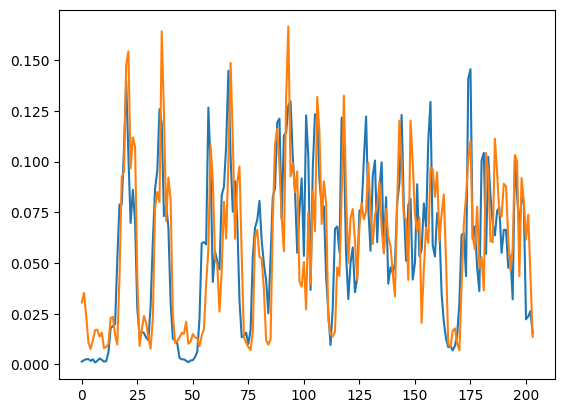

In [29]:
plt.plot(spred1a[4])
plt.plot(bs1a[0])

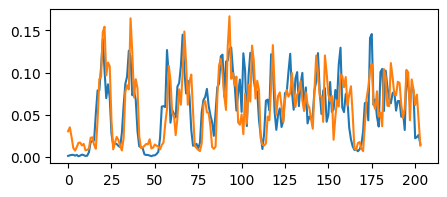

In [30]:
plt.figure(figsize=(5,2))
plt.plot(spred1a[4])
plt.plot(bs1a[0])
#plt.savefig('./graphs/network_output_template.pdf', bbox_inches='tight')
plt.show()

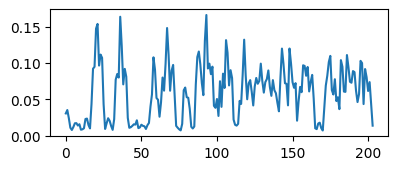

In [31]:
plt.figure(figsize=(4.355,1.65))
plt.plot(bs1a[0])
#plt.savefig('./graphs/network_output2.pdf', bbox_inches='tight')
plt.show()

In [32]:
11.062/2.54

4.35511811023622